In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score as auc
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score as auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
%load_ext autoreload
%autoreload 2

In [4]:
def NumCatPipeline(cat_cols,num_cols):
    """Input: list of categorical columns and numerical columns
            *for LGBM can enter empty list for categorical
       Output: full pipeline with column transformer for preprocessing data"""
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import RobustScaler, OneHotEncoder,MinMaxScaler,OrdinalEncoder
    from sklearn.compose import ColumnTransformer

    #num_pipeline = Pipeline([('mm_scaler', RobustScaler(quantile_range=(0,99))), ])
    num_pipeline = Pipeline([('mm_scaler', MinMaxScaler()), ])

    cat_pipeline = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"),)])
   


    full_pipeline = ColumnTransformer([("num", num_pipeline,num_cols),("cat", cat_pipeline,cat_cols),],remainder="passthrough")
    return full_pipeline#,full_pipeline.get_feature_names_out(list(num_cols)+list(cat_cols))

def filtering_df(df,test_size=0.2,random_state=0):
    print(df.shape)
    df.head(5)
    df.drop_duplicates("patient_nbr",inplace=True)
    df=df[~df["discharge_disposition_id"].isin([11,13,14,19,20,21])].copy()
    df=df[df["gender"]!="Unknown/Invalid"].copy()

    df.drop(["encounter_id","patient_nbr","weight"],axis=1,inplace=True)
    df["readmitted"]=df["readmitted"]=="<30"
    df.dtypes
    df[df.select_dtypes(include="object").columns]=df[df.select_dtypes(include="object").columns].astype("category")

    y=df["readmitted"]
    df.drop("readmitted",axis=1,inplace=True)

    return df,y


In [5]:
"""df=pd.read_csv("/home/labs/nyosef/elibe/ML_healthcare/data/dataset_diabetes/diabetic_data.csv")
print(df.shape)
df.head(5)
df.drop_duplicates("patient_nbr",inplace=True)
df=df[~df["discharge_disposition_id"].isin([11,13,14,19,20,21])].copy()
df=df[df["gender"]!="Unknown/Invalid"].copy()
df=df.drop_duplicates("patient_nbr",keep="first")
df=df.drop(["encounter_id","patient_nbr","weight"],axis=1)
df["readmitted"]=df["readmitted"]=="<30"
df.dtypes
df[df.select_dtypes(include="object").columns]=df[df.select_dtypes(include="object").columns].astype("category")

y=df["readmitted"]
df.drop("readmitted",axis=1,inplace=True)
full_pipeline=NumCatPipeline(cat_cols=df.select_dtypes(include="category").columns,num_cols=df.select_dtypes(include="number").columns)
X_train_, X_test_, y_train_, y_test_= train_test_split(df,y,test_size=0.2,random_state=0,stratify=y)
X_train_=full_pipeline.fit_transform(X_train_)
X_test_=full_pipeline.transform(X_test_)"""

(101766, 50)


In [7]:
df=pd.read_csv("/home/labs/nyosef/elibe/ML_healthcare/data/dataset_diabetes/diabetic_data.csv")
df,y=filtering_df(df)
X_train_, X_test_, y_train_, y_test_ = train_test_split(df, y, test_size=0.2, random_state=0, stratify=y)
X_test_.head(3)

(101766, 50)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
42198,Caucasian,Female,[70-80),1,1,7,4,?,?,22,...,No,No,Steady,No,No,No,No,No,Ch,Yes
96451,Caucasian,Female,[60-70),1,1,7,6,CP,?,47,...,No,No,Steady,No,No,No,No,No,Ch,Yes
77820,Caucasian,Male,[70-80),1,1,7,7,MC,Emergency/Trauma,60,...,No,No,No,No,No,No,No,No,Ch,Yes


In [8]:

full_pipeline=NumCatPipeline(cat_cols=X_train_.select_dtypes(include="category").columns,num_cols=X_train_.select_dtypes(include="int64").columns)
X_train_=full_pipeline.fit_transform(X_train_)
X_test_=full_pipeline.transform(X_test_)
X_train_.shape, X_test_.shape, y_train_.value_counts(), y_test_.value_counts()

((55976, 2291),
 (13994, 2291),
 readmitted
 False    50954
 True      5022
 Name: count, dtype: int64,
 readmitted
 False    12739
 True      1255
 Name: count, dtype: int64)

In [9]:
#default params
cv_score=[]
test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    brf_params={

    'max_features': ['sqrt'],

  
    }
    brf = BalancedRandomForestClassifier(random_state=seed,verbose=0,bootstrap=True,replacement=False,oob_score=True)
    model = GridSearchCV(estimator = brf,param_grid = brf_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=0)



    print(X_train_.shape)
    model.fit(X_train_,y_train_)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))


(55976, 2291)


/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementa

*** 0.6319878634084057
0.6021387720176676
cv_score mean: 0.6319878634084057
cv_score std: 0.0
test_score soft mean: 0.6480358806551015
test_score soft std: 0.0
test_score hard mean: 0.6021387720176676
test_score hard std: 0.0


In [10]:
cv_score=[]
test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    brf_params={

    'max_features': ['sqrt'], 
    "max_samples":[0.1,0.2,0.3],
    "max_depth":[10,15,20],
    "n_estimators":[100,500,1000,2000]
  
    }
    brf = BalancedRandomForestClassifier(random_state=seed,verbose=0,bootstrap=True,replacement=False,oob_score=True)
    model = GridSearchCV(estimator = brf,param_grid = brf_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=0)



    print(X_train_.shape)
    model.fit(X_train_,y_train_)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))
model.best_params_,model.best_score_

(55976, 2291)


/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementa

*** 0.6452390833176423
0.6033758364766852
cv_score mean: 0.6452390833176423
cv_score std: 0.0
test_score soft mean: 0.6515786606302634
test_score soft std: 0.0
test_score hard mean: 0.6033758364766852
test_score hard std: 0.0


({'max_depth': 20,
  'max_features': 'sqrt',
  'max_samples': 0.2,
  'n_estimators': 1000},
 0.6452390833176423)

In [11]:
cv_score=[]
test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    brf_params={

    'max_features': ['sqrt', 'log2'],
    "max_samples":[0.1,0.2,0.3,0.4,0.5,0.6,],
    "max_depth":range(16,30,2),
    "n_estimators":range(500,1500,50),
    "min_samples_split":range(2,100,2),
    "min_samples_leaf":range(2,100,2),
    "ccp_alpha":np.geomspace(1e-6,1e-2,10)

  
    }
    brf = BalancedRandomForestClassifier(random_state=seed,verbose=0,bootstrap=True,replacement=False,oob_score=True)
    model = RandomizedSearchCV(estimator = brf,param_distributions= brf_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=1,n_iter=200)



    print(X_train_.shape)
    model.fit(X_train_,y_train_)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))
model.best_params_,model.best_score_

(55976, 2291)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementa

*** 0.6465955565342753
0.6086040640014713
cv_score mean: 0.6465955565342753
cv_score std: 0.0
test_score soft mean: 0.6523547070842151
test_score soft std: 0.0
test_score hard mean: 0.6086040640014713
test_score hard std: 0.0


({'n_estimators': 700,
  'min_samples_split': 22,
  'min_samples_leaf': 2,
  'max_samples': 0.5,
  'max_features': 'sqrt',
  'max_depth': 28,
  'ccp_alpha': 7.742636826811277e-06},
 0.6465955565342753)

In [13]:
import optuna
def objective(trial,data,target):
    param={
    "n_estimators":[trial.suggest_int("n_estimators",500,1000)],
    "max_samples":[0.2],
        "max_depth":[20],
        "min_samples_split":[trial.suggest_int("min_samples_split",5,100)],
        "min_samples_leaf":[trial.suggest_int("min_samples_leaf",5,100)],
        "max_features":[trial.suggest_categorical("max_features",["sqrt","log2"])],
        "ccp_alpha":[trial.suggest_float("ccp_alpha",1e-5,1,log=True,)],
        
    }
    brf = BalancedRandomForestClassifier(random_state=0,verbose=0,
                                     oob_score=True,
                                      sampling_strategy=1.0, 
                                      replacement=False,bootstrap=True,
                                      
                                      )

    model = GridSearchCV(estimator = brf,param_grid = param,cv=5,scoring="roc_auc",n_jobs=-1,verbose=0,)



    model.fit(data,target)

    return model.best_score_ - model.cv_results_["std_test_score"][model.best_index_]
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, data=X_train_, target=y_train_), n_trials=85,)
print("***",study.best_params, study.best_value)

[I 2024-06-02 11:45:45,953] A new study created in memory with name: no-name-09b773a2-b48e-433c-bd45-f85f674b5e17
[I 2024-06-02 11:47:49,281] Trial 0 finished with value: 0.6185568582307426 and parameters: {'n_estimators': 760, 'min_samples_split': 31, 'min_samples_leaf': 50, 'max_features': 'log2', 'ccp_alpha': 0.0023779282696981116}. Best is trial 0 with value: 0.6185568582307426.
[I 2024-06-02 11:48:58,220] Trial 1 finished with value: 0.595740540918359 and parameters: {'n_estimators': 748, 'min_samples_split': 32, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'ccp_alpha': 0.007968956928399691}. Best is trial 0 with value: 0.6185568582307426.
[I 2024-06-02 11:50:26,788] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 949, 'min_samples_split': 95, 'min_samples_leaf': 84, 'max_features': 'sqrt', 'ccp_alpha': 0.022593082622233286}. Best is trial 0 with value: 0.6185568582307426.
[I 2024-06-02 11:51:37,362] Trial 3 finished with value: 0.5 and parameters: {'n_estima

In [ ]:
Trial 78 finished with value: 0.6381209604389473 and parameters: {'n_estimators': 617, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'ccp_alpha': 7.995838696488338e-05}. Best is trial 78 with value: 0.6381209604389473.

In [1]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score as auc, balanced_accuracy_score as acc,f1_score as f1

In [5]:
df=pd.read_csv("/home/labs/nyosef/elibe/ML_healthcare/data/dataset_diabetes/diabetic_data.csv")
df,y=filtering_df(df)

test_score_auc=[]
test_score_f1=[]
test_score_bac=[]

for seed in range(15):    
    X_train_, X_test_, y_train_, y_test_ = train_test_split(df, y, test_size=0.2, random_state=seed, stratify=y)

    brf_params={"max_samples":0.5,"max_depth":20,'n_estimators': 617, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'ccp_alpha': 7.995838696488338e-05}
    
    model= BalancedRandomForestClassifier(random_state=seed,verbose=0,bootstrap=True,replacement=False,oob_score=True,**brf_params)


    prep_pipe=NumCatPipeline(cat_cols=df.select_dtypes(include="category").columns,num_cols=df.select_dtypes(include="int64").columns)
    pipe_prep_train = Pipeline(steps = [
        ('prep_pipeline', prep_pipe),
        ('train', model),
    ])
    #fit data
    pipe_prep_train.fit(X_train_,y_train_)
    test_score_auc.append(metrics.roc_auc_score(y_test_,pipe_prep_train.predict_proba(X_test_,)[:,1]))
    
    test_score_f1.append(metrics.f1_score(y_test_,pipe_prep_train.predict(X_test_)))
    test_score_bac.append(metrics.balanced_accuracy_score(y_test_,pipe_prep_train.predict(X_test_)))
print("test_score auc mean:",np.mean(test_score_auc))
print("test_score auc std:",np.std(test_score_auc))
print("test_score f1 mean:",np.mean(test_score_f1))
print("test_score f1 std:",np.std(test_score_f1))
print("test_score bac mean:",np.mean(test_score_bac))
print("test_score bac std:",np.std(test_score_bac))


(101766, 50)
test_score auc mean: 0.644040287029395
test_score auc std: 0.005602220119917507
test_score f1 mean: 0.2145071414198566
test_score f1 std: 0.0027559469887867834
test_score bac mean: 0.6043673999608233
test_score bac std: 0.0043792726821877915


auc                     Axes(0.125,0.11;0.227941x0.77)
f1                   Axes(0.398529,0.11;0.227941x0.77)
balanced_accuracy    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

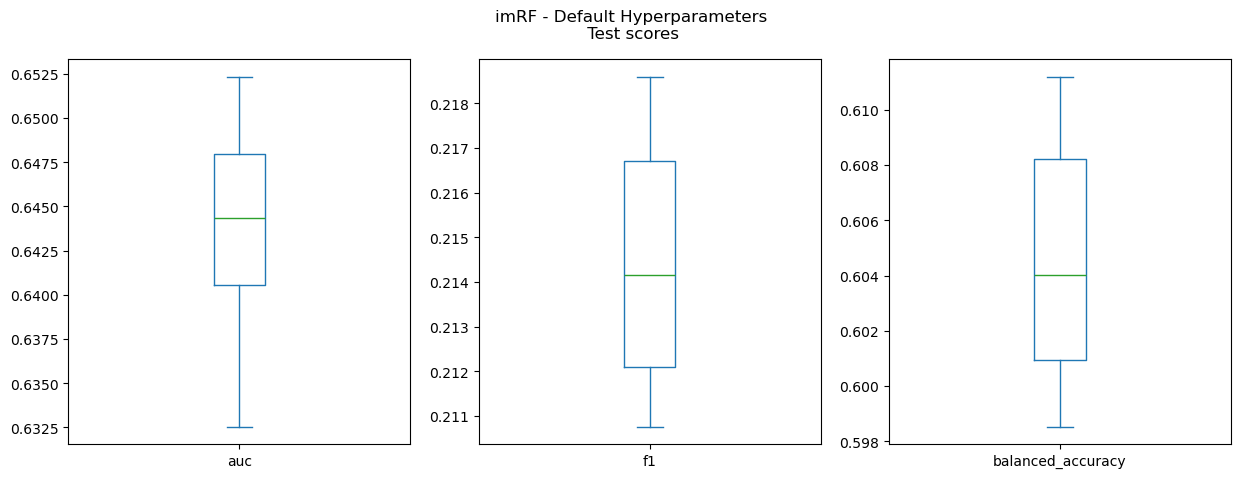

In [6]:
pd.DataFrame({"auc":test_score_auc,"f1":test_score_f1,"balanced_accuracy":test_score_bac}).plot(kind="box",subplots=True,layout=(1,3),figsize=(15,5),title="imRF - Default Hyperparameters\n Test scores")

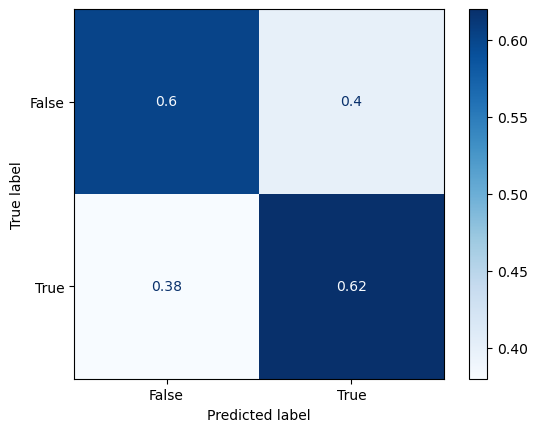

In [11]:
metrics.ConfusionMatrixDisplay.from_estimator(pipe_prep_train,X_test_,y_test_,normalize="true",cmap="Blues",)